In [1]:
#-------------------------Imports---------------------------
import numpy as np
#import healpy as hp
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits import mplot3d
#import sympy as sy #symbolic algebra
import pandas as pd
from numpy.random import random

from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.stats import uniform
from scipy import interpolate

import os
from astropy.cosmology import Planck15
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table

###########################
# CONSTANTS
###########################
H0GLOB= 69#67.9 #69
Om0GLOB=0.3
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s

xmax=100
ymax=100
zmax=100
half_box_size=2

Npoints=1000
Sigma=10

cosmoglob = Planck15
cosmofast = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
H0=cosmoglob.H(0).value
h=H0/100
print(cosmoglob)

FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)


In [17]:
#--------------------------definitions-------------------------
def NumOfDS(x,y,z):
    #this will evaluate the dN/dz
    r=np.sqrt(x**2+y**2+z**2)
    #numberofDS=1000/r
    numberofDS=2
    num=int(numberofDS)
    #print(num)
    if num>0:
        return num
    else:
        return 1
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))       
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples
#--------------Placer-----------------------------
def DS_Maker(radii,perc,numHost,xhost,yhost,zhost):
    #the DSs are generated in a sphere, centered on the host. and the distance must follow
#the correlation distribution. 
#To generate points on a unit sphere see https://mathworld.wolfram.com/SpherePointPicking.html
# A python implementation https://stackoverflow.com/questions/5408276/sampling-uniformly-distributed-random-points-inside-a-spherical-volume
    #remember: you have to return also the indices of the hosts that have DSs
    x_Dark=[]
    y_Dark=[]
    z_Dark=[]
    phi_to_return=[]
    theta_to_return=[]
    r_to_return=[]
    full_r=[]
    
    arr_n=[]
    NDS=int(perc*numHost)
    indices=np.zeros(NDS)
    
    for k in range(NDS):
        i=np.random.randint(0, numHost-1)
        indices[k]=i
        dist_x=xhost[i]
        dist_y=yhost[i]
        dist_z=zhost[i]
        n=NumOfDS(dist_x,dist_y,dist_z)
        arr_n=np.append(arr_n,n)
        for d in range(n):
            phi =np.random.uniform(0,2*np.pi)
            costheta =np.random.uniform(-1,1)
            theta = np.arccos(costheta)
            r=np.random.choice(radii)
            full_r=np.append(full_r,r)
            if r>=distcut:
                x_DS = r * np.sin( theta) * np.cos( phi )
                y_DS = r * np.sin( theta) * np.sin( phi )
                z_DS = r * np.cos( theta )
                r_to_return=np.append(r_to_return,r)
            else:
                d=d-1

            #real values: do some check
            
            theta_to_return=np.append(theta_to_return,costheta)
            phi_to_return=np.append(phi_to_return,phi)
        
            x_Dark=np.append(x_Dark,dist_x+x_DS)
            y_Dark=np.append(y_Dark,dist_y+y_DS)
            z_Dark=np.append(z_Dark,dist_z+z_DS)
    #--------only unique indices of host-DS
    filtered=np.unique(indices.astype(int))
    return x_Dark, y_Dark, z_Dark, filtered, arr_n,r_to_return,theta_to_return,phi_to_return,full_r


In [ ]:
#----------------------Create the box & fill it with hosts-------------------
#x=np.random.normal(loc=0,scale=Sigma,size=Npoints)
#y=np.random.normal(loc=0,scale=Sigma,size=Npoints)
#z=np.random.normal(loc=0,scale=Sigma,size=Npoints)

In [3]:
#------------read the flagship-------------------------------------
dat = Table.read('flagship.fits', format='fits')
df = dat.to_pandas()#all good, is an only text fits
print(df.columns)

Index(['ra_gal', 'dec_gal', 'true_redshift_gal', 'observed_redshift_gal',
       'x_gal', 'y_gal', 'z_gal', 'vx_gal', 'vy_gal', 'vz_gal'],
      dtype='object')


In [238]:
#distances are in Mpc/h and are comoving distances. We need luminosity distances and Mpc 
host_x=df['x_gal'].values/h #restore the right units
host_y=df['y_gal'].values/h
host_z=df['z_gal'].values/h
host_obs_redshift=df['observed_redshift_gal'].values
host_true_redshift=df['true_redshift_gal'].values
lum_host_x=host_x*(1+host_true_redshift)
lum_host_y=host_y*(1+host_true_redshift)
lum_host_z=host_z*(1+host_true_redshift)
dl=np.sqrt(lum_host_x[-1]**2+lum_host_y[-1]**2+lum_host_z[-1]**2)
dc=np.sqrt(host_x[-1]**2+host_y[-1]**2+host_z[-1]**2)

#print(dc,dl,dl/dc-1,host_obs_redshift[-1],host_true_redshift[-1])

In [239]:
print(dc,dl,dl/dc-1,host_obs_redshift[-1],host_true_redshift[-1])

5265.413588972411 15786.827725167199 1.9982122882484012 1.9981294 1.9982125


In [ ]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
num=int(df.shape[0]*0.0001)
ax.scatter(np.random.choice(lum_host_x,num), np.random.choice(lum_host_y,num),
           np.random.choice(lum_host_z,num), c = 'b', s = 5)
ax.set_title('Host-Dristibution')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
#plt.savefig('HostDist.pdf')
ax.view_init(60, 65)#rotation along x z
figtot2dxy = plt.figure(figsize = (10,10))
ax = plt.axes()
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(linestyle='dotted', linewidth='0.6')
ax.scatter(np.random.choice(lum_host_x,num), np.random.choice(lum_host_y,num),
           c = 'b', marker="*", label='Host')
plt.legend(loc='upper left');

In [5]:
#----------------MC-rejection-with-CDF----------------------
r0=5*h
gamma=0.2
#rmin=0.1*h
rmin=0
distcut=0.1*h
rmax=10*h
#target function
target_dist= lambda r: (r/r0)**(gamma)
#x = sy.Symbol('x')
#norm=sy.integrate(target_dist(x), (x, rmin, rmax))
#print(norm)
values=return_samples(target_dist,rmin,rmax,1000000)
real_values=values[values>=distcut]
#shift=len(values)-len(real_values)


In [6]:
print(len(real_values))
fast_shift=1-len(real_values)/len(values)
print(1-len(real_values)/len(values))

996031
0.003969


In [18]:
Nhost=df.shape[0]
x_Dark, y_Dark, z_Dark, filtered,arr_n,real_r,real_theta,real_phi,full_r=DS_Maker(values,0.001,Nhost,host_x,host_y,host_z)
print(len(x_Dark))

32810


Text(0.5, 0, 'z')

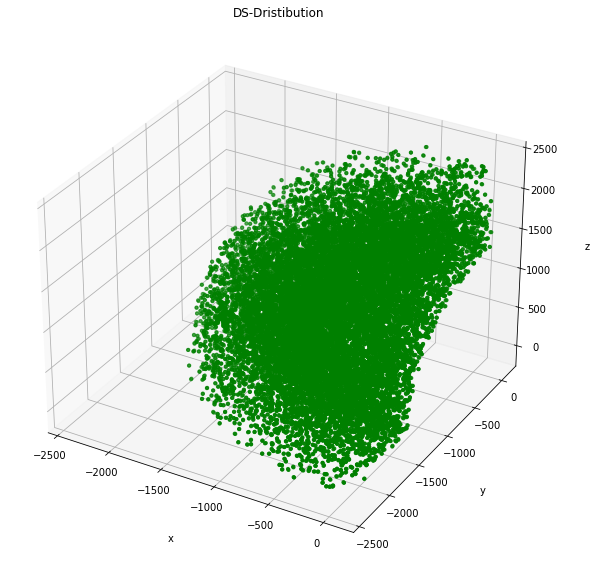

In [20]:
fig2 = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(x_Dark, y_Dark, z_Dark, c = 'g', s = 10)
ax.set_title('DS-Dristibution')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
#plt.savefig('DSDist.pdf')

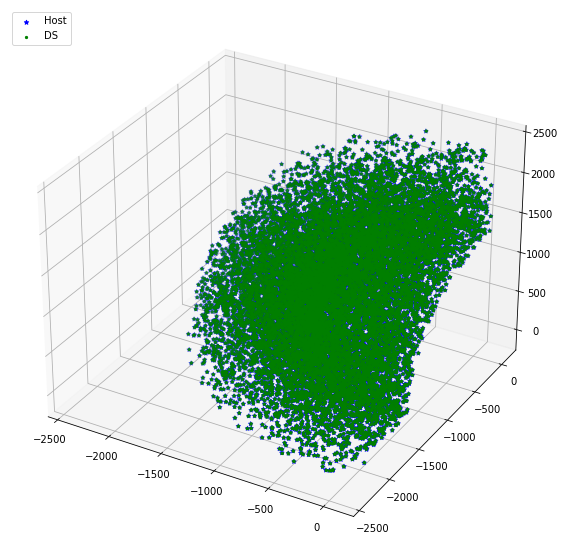

In [22]:
figtot = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
ax1 = figtot.add_subplot(111,projection='3d')

ax1.scatter(np.take(host_x,filtered), np.take(host_y,filtered),np.take(host_z,filtered), c = 'b', marker="*", label='Host')
ax1.scatter(x_Dark, y_Dark, z_Dark, s=5, c = 'g', marker="o", label='DS')
plt.legend(loc='upper left');
#plt.savefig('DS_and_Host.pdf')

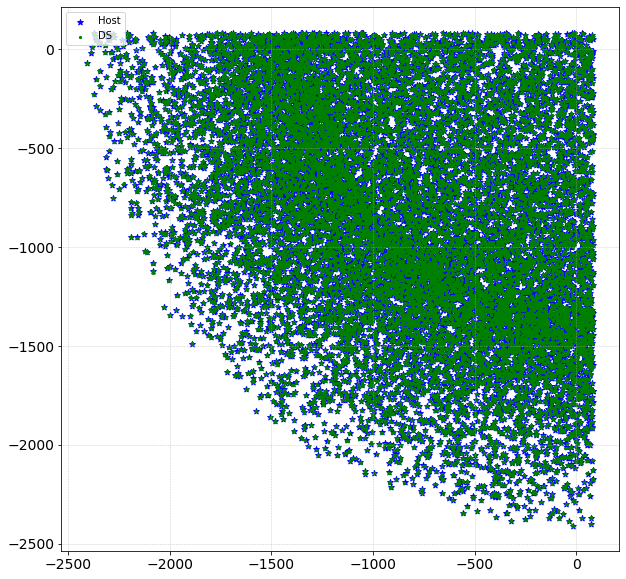

In [23]:
figtot2dxy = plt.figure(figsize = (10,10))
ax = plt.axes()
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(linestyle='dotted', linewidth='0.6')
ax.scatter(np.take(host_x,filtered), np.take(host_y,filtered), c = 'b', marker="*", label='Host')
ax.scatter(x_Dark, y_Dark, s=5, c = 'g', marker="o", label='DS')
plt.legend(loc='upper left');
#plt.savefig('DS_and_Host_xy.pdf')

In [ ]:
'''
Some checks on what we have so far
Do To list:
1) visual proof of distributions
'''

(13742.828092451779, 106600.0)

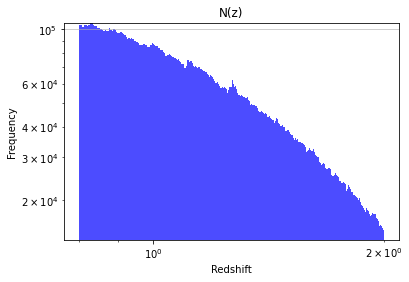

In [27]:
#--------------------host redshift distribution------------------------------------
n, bins, patches = plt.hist(x=host_obs_redshift, bins='auto', color='b',
                            alpha=0.7, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title('N(z)')
maxfreq = n.max()
plt.yscale('log')
plt.xscale('log')
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

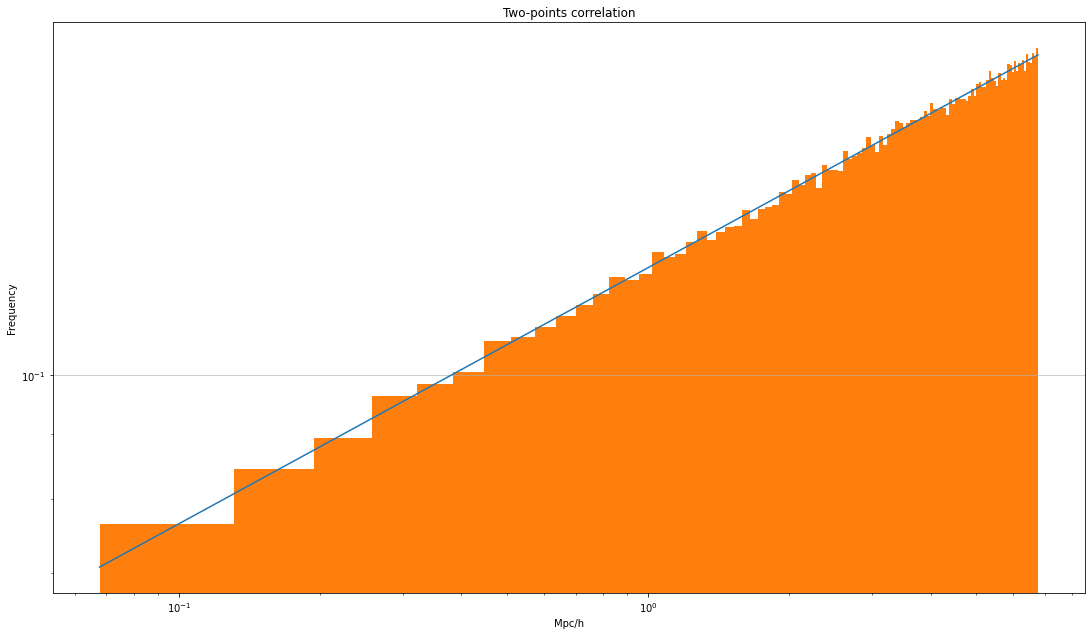

In [28]:
## plot of the rejection results

x = np.linspace(0.1*h,rmax,1000000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.set_ylabel('probability density')
ax.plot(x,target_dist(x)/np.sum(target_dist(x)*(x[1]-x[0])) )
#ax.plot(x,target_dist(x)/norm ) #slow
ax.hist(values,bins='auto',density=True,range=(x.min(),x.max()))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.title('Two-points correlation')
plt.show() 

True
True


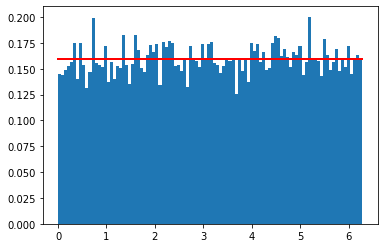

In [32]:
#---------------Distribution of phi------------------
count, bins, ignored = plt.hist(real_phi, 100, density=True)
line=np.ones_like(bins)
line=line/(2*np.pi)
plt.plot(bins, line, linewidth=2, color='r')
plt.show()

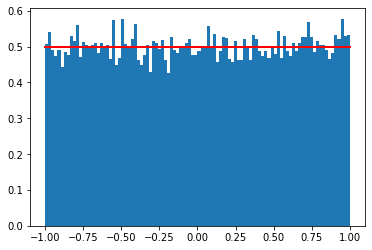

In [48]:
#---------------Distribution of cos(theta)------------------
count, bins, ignored = plt.hist(real_theta, 100, density=True)#real_theta is cos(theta)
line=np.ones_like(bins)
line=line/(2)
plt.plot(bins, line, linewidth=2, color='r')
plt.show()

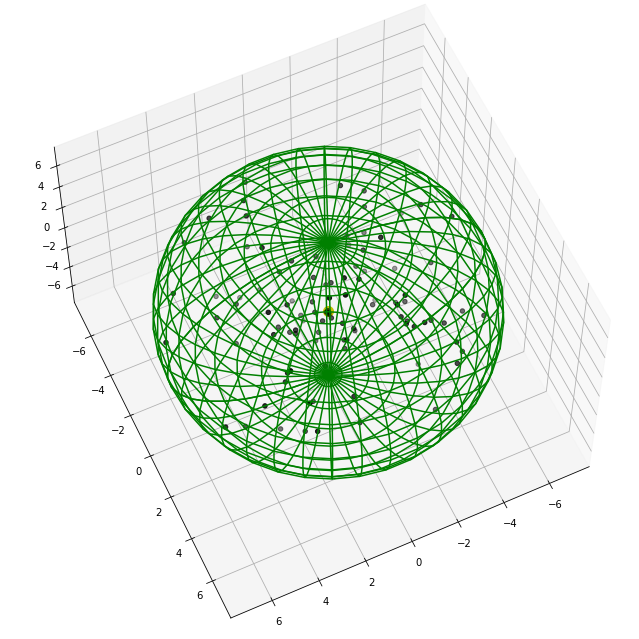

In [31]:

Npoints=100
esp=1
phi =np.random.uniform(0,2*np.pi,Npoints)
costheta =np.random.uniform(-1,1,Npoints)
theta = np.arccos(costheta)
r=np.random.choice(values,Npoints)
wire_phi = np.linspace(0, np.pi, 20)
wire_theta = np.linspace(0, 2 * np.pi, 40)
x_sph = r * np.sin( theta) * np.cos( phi )
y_sph = r * np.sin( theta) * np.sin( phi )
z_sph = r * np.cos( theta )
x = rmin*np.outer(np.sin(wire_theta), np.cos(wire_phi))# outer product i.e. line*row
y = rmin*np.outer(np.sin(wire_theta), np.sin(wire_phi))
z = rmin*np.outer(np.cos(wire_theta), np.ones_like(wire_phi))
x_out = rmax*np.outer(np.sin(wire_theta), np.cos(wire_phi))# outer product i.e. line*row
y_out = rmax*np.outer(np.sin(wire_theta), np.sin(wire_phi))
z_out = rmax*np.outer(np.cos(wire_theta), np.ones_like(wire_phi))
fig, ax = plt.subplots(1, 1,subplot_kw={'projection':'3d'})
fig.set_size_inches(11.5, 11.5)
ax.scatter(x_sph, y_sph , z_sph, s=20, c='k', zorder=10)
ax.scatter(0, 0 , 0, s=100, c='y', zorder=10)
#ax.plot_wireframe(x, y, z, color='b', rstride=1, cstride=1)
ax.plot_wireframe(x_out, y_out, z_out, color='g', rstride=1, cstride=1)

ax.view_init(60, 65)#rotation along x z

In [ ]:
#---------- Test using real DS data------------------------------


In [76]:
bins = 100
counts_cdf = []
counts_new_cdf = []
r_right=[]
#r=np.random.choice(values,70000)
step = real_r.max()/bins
R_min = distcut
#new_values=values[values>=R_min]

for myi in range(bins):
    right = R_min + (myi+0)*step
    bools_old = full_r<=right
    bools_new = real_r<=right
    
    counts_cdf = np.append(counts_cdf, len(full_r[bools_old]))
    counts_new_cdf = np.append(counts_new_cdf, len(real_r[bools_new]))
    
    r_right = np.append(r_right, right)
    
    #print(counts_cdf[myi],counts_new_cdf[myi])
    #print(counts_cdf[myi]-counts_new_cdf[myi])
shift=counts_cdf[0]-counts_new_cdf[0]
#shift=0.004*len(real_r)
#shift=fast_shift*len(real_r)
counts_cdf=counts_cdf/counts_cdf.max()
counts_new_cdf=counts_new_cdf+shift
counts_new_cdf=counts_new_cdf/counts_new_cdf.max()

    
    

CDF normalization 6.484402213958262	 Prefactor 0.1542162202473205


Text(0.5, 0, 'Mpc/h')

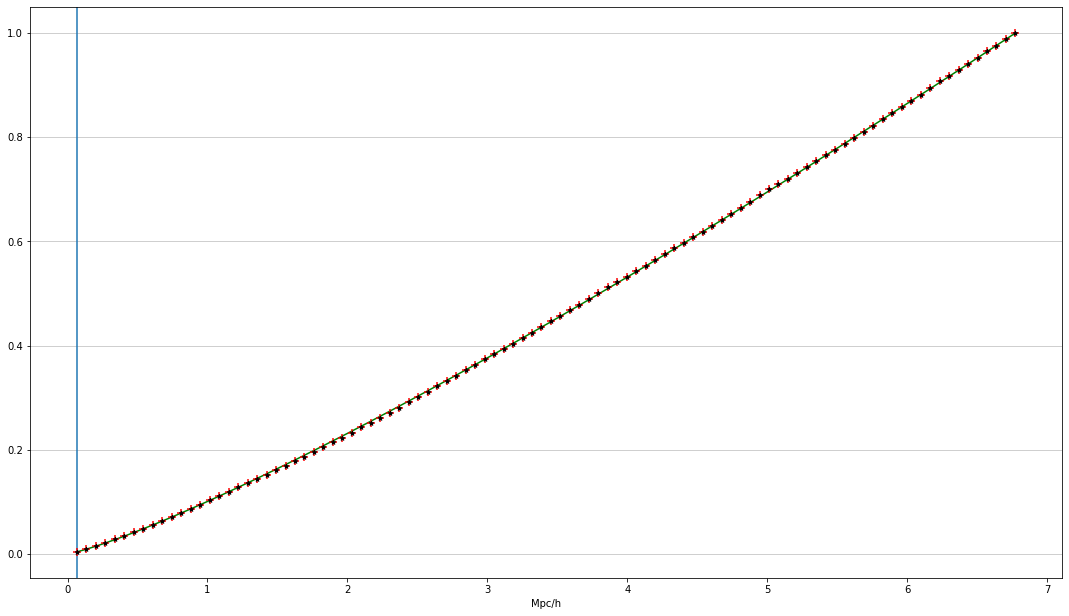

In [218]:
x = np.linspace(R_min,rmax,1000000)
zeta=1.2#gamma+1
norm=(rmax**(zeta))/((zeta)*r0**gamma)
print('CDF normalization {}\t Prefactor {}'.format(norm,1/norm))
handmade_cdf=lambda x: (x**(zeta))/(rmax**(zeta))


fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')

#ax.set_ylabel('probability density')

ax.plot(x,handmade_cdf(x) ,color='g')
plt.axvline(x=distcut)
ax.scatter(r_right, counts_new_cdf , s=50, marker='+', c='r', zorder=10)
ax.scatter(r_right, counts_cdf , s=20,marker='*', c='k', zorder=10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
#plt.yscale('log')
#plt.xscale('log')
#plt.savefig('DS_cumulative.pdf')

Text(0.5, 0, 'Mpc/h')

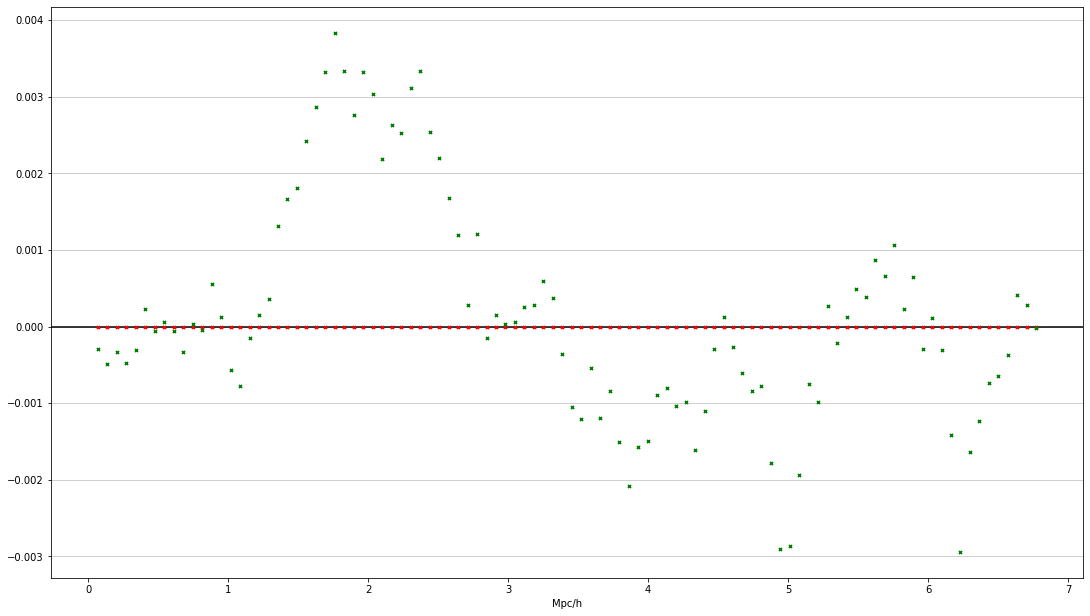

In [78]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')

#ax.set_ylabel('probability density')

#ax.plot(x,handmade_cdf(x) ,color='g')
#plt.axvline(x=rmin)
ax.scatter(r_right, counts_cdf-counts_new_cdf , s=10,marker='x', c='r', zorder=10)#diff between full dist and dist with r_cut
ax.scatter(r_right, handmade_cdf(r_right)-counts_new_cdf , s=10,marker='x', c='g', zorder=10)#diff between cumulative and dist with r_cut
plt.axhline(y=0, color='k', linestyle='-')
#plt.ylim(bottom=-0.001,top=0.001)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
#plt.yscale('log')
#plt.xscale('log')
#plt.savefig('DS_cumulative.pdf')

In [117]:
print(real_r.mean(),real_r.std(),real_r.var(),real_r.std()**2 -real_r.var())

3.711788912710111 1.8701753738890343 3.4975559291009897 -4.440892098500626e-16


In [185]:
norma_x02=((real_r.max()**1.2)-(real_r.min()**1.2))/1.2

In [186]:
esp=2.2
A=(real_r.min())**(esp)
B=(real_r.max())**(esp)
handmademean=((B-A)/(esp))/norma_x02
print(handmademean)

3.7094927460285456


In [120]:
esp=3.2
A=(real_r.min())**(esp)
B=(real_r.max())**(esp)
handmadevar=((B-A)/(esp))/norma_x02
handmadevar=handmadevar-handmademean**2
handmadestd=np.sqrt(handmadevar)
print(handmadestd)


1.8750199551629845


In [223]:
print(counts_new_cdf.mean(),counts_new_cdf.std(),counts_new_cdf.var())

0.45939073453215484 0.29715117129226437 0.08829881860036463


In [229]:

esp=2.2
A=(counts_new_cdf.min())**(esp)
B=(counts_new_cdf.max())**(esp)
handmademean=((B-A)/(esp))
print(handmademean)
esp=3.2
A=(counts_new_cdf.min())**(esp)
B=(counts_new_cdf.max())**(esp)
handmadevar=((B-A)/(esp))
handmadevar=handmadevar-handmademean**2
handmadestd=np.sqrt(handmadevar)
print(handmadestd)
print(handmadevar)

0.45454267582223057
0.3254088930942485
0.10589094770482405


In [158]:
bins = 100
freq_r = []
r_center=[]
step = real_r.max()/bins
R_min = distcut
left=R_min
for myi in range(bins-1):
    right = left+ (myi+1)*step
    bools_left = left<real_r
    bools_right=real_r<=right
    bools_new= bools_left&bools_right
    #print(bools_left,bools_right,bools_new)
    freq_r = np.append(freq_r, len(real_r[bools_new]))
    
    r_center = np.append(r_center, left+step/2)
    left=right

array([99, 74, 40, ..., 83, 58, 29])

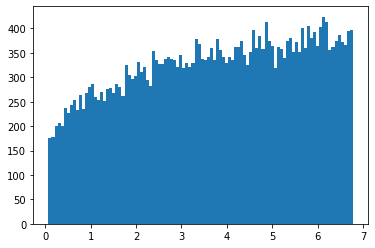

In [173]:
count= plt.hist(real_r, 100)#real_theta is cos(theta)

Text(0.5, 0, 'Mpc/h')

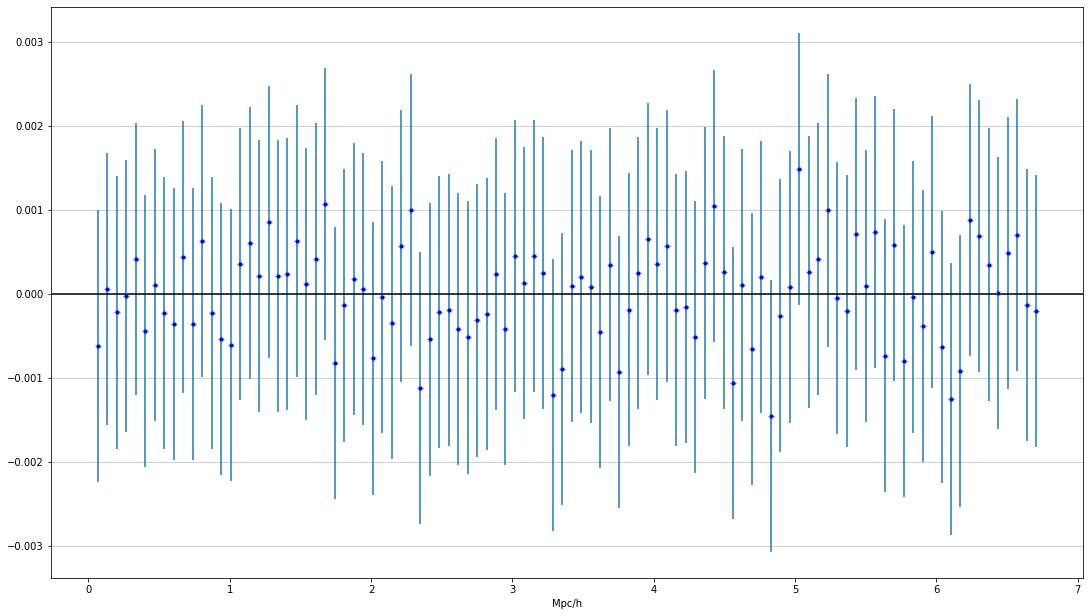

In [235]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')

#ax.set_ylabel('probability density')

xx=count[1]
#print(xx)
xx=xx[:-1]
#print(xx)
yy=count[0]
yy=yy/yy.sum()
arr_teo=target_dist(xx)
arr_teo=arr_teo/arr_teo.sum()
res=arr_teo-yy
#ax.scatter(xx, yy , s=10,marker='x', c='g', zorder=10)
ax.scatter(xx,res , s=10,marker='x', c='b', zorder=10)#diff between cumulative and dist with r_cut
plt.axhline(y=0, color='k', linestyle='-')
plt.errorbar(xx, res, yerr=arr_teo.std(), fmt="+")
#plt.ylim(bottom=-0.001,top=0.001)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
#plt.yscale('log')
#plt.xscale('log')
#plt.savefig('DS_cumulative.pdf')

In [233]:
res=arr_teo-yy
mu=res.mean()
std=yy.std()
std_teo=arr_teo.std()
print(mu,std,std_teo)

-2.3418766925686897e-19 0.0016935919336297177 0.0016206907447452997


In [ ]:
#--------------------SDSS like-------------------------
